# 🎯 | Cora-For-Zava: Cost-Effective Model Distillation

Welcome! This notebook will guide you through creating a custom grader and using model distillation to transfer knowledge from a large, expensive model to a smaller, faster, and more cost-effective one.

## 🛒 Our Zava Scenario

**Cora** is a customer service chatbot for **Zava** - a fictitious retailer of home improvement goods for DIY enthusiasts. While our fine-tuned model provides excellent tone and style, it's using a large, expensive model (GPT-4) for a focused task. Model distillation allows us to transfer this specialized knowledge to a smaller model (GPT-4.1-nano) for better cost-efficiency and performance.

## 🎯 What You'll Build

By the end of this notebook, you'll have:
- ✅ Created a custom grader to evaluate response quality consistently
- ✅ Established baseline "gold standard" responses for evaluation
- ✅ Defined clear grading criteria for tone and style assessment
- ✅ Used distillation to transfer knowledge to a smaller model
- ✅ Measured performance improvements in cost and latency
- ✅ Validated that the distilled model maintains quality standards

## 💡 What You'll Learn

- How to design custom evaluators for specific business criteria
- How to create effective grading rubrics for AI model assessment
- How model distillation transfers knowledge from teacher to student models
- How to balance model performance with cost and speed requirements
- How to measure and validate distillation effectiveness
- When to use distillation vs. fine-tuning vs. prompt engineering

> **Key Insight**: Model distillation enables you to achieve specialized performance with smaller, faster, cheaper models by transferring knowledge from larger, more capable "teacher" models.

Ready to optimize your model for cost and performance? Let's get started! 🚀

---

## Step 1: Verify Environment Variables

The following environment variables should already be configured in your `.env` file from the earlier setup steps:

- **AZURE_OPENAI_API_KEY**: Your Azure OpenAI API key
- **AZURE_OPENAI_ENDPOINT**: Your Azure OpenAI service endpoint
- **AZURE_OPENAI_API_VERSION**: The API version to use
- **AZURE_SUBSCRIPTION_ID**: Your Azure subscription ID
- **AZURE_RESOURCE_GROUP**: Your Azure resource group name
- **AZURE_AI_PROJECT_NAME**: Your Microsoft Foundry project name

> **Note**: Model distillation requires access to both large teacher models (GPT-4) and smaller student models (GPT-4.1-nano) for optimal cost-performance optimization.

In [1]:
# First, make sure required environment variables are set
import os

openai_key = os.getenv("AZURE_OPENAI_API_KEY")
openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model_name = "gpt-4.1"
api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2025-02-01-preview")

if not openai_key or not openai_endpoint:
    print("Error: Missing AZURE_OPENAI_KEY or AZURE_OPENAI_ENDPOINT environment variable.")

print("Using Model:", model_name)
print("Using API Version:", api_version)

Using Model: gpt-4.1
Using API Version: 2025-02-01-preview


In [2]:
# Then create an Azure OpenAI Client instance
from openai import AzureOpenAI

client = AzureOpenAI(
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),
    api_key=os.environ.get("AZURE_OPENAI_API_KEY"),
    api_version="2025-04-01-preview",
)

In [3]:
# And create a handy UUID we can use to track each run of this notebook
import uuid
UNIQUE_ENOUGH_KEY = str(uuid.uuid4()).split("-")[0]

## Step 2: Building Our Custom Grader

Model distillation involves transferring knowledge from a "teacher" model to a "student" model, enabling the student to perform specialized tasks with comparable accuracy but better efficiency. To measure distillation effectiveness, we need a consistent evaluation method.

### 🎯 The Distillation Process

**Teacher Model** (GPT-4) → **Knowledge Transfer** → **Student Model** (GPT-4.1-nano)
- Large, capable, expensive → Specialized knowledge → Small, fast, cost-effective

### 🏗️ Building an Effective Grader

We'll create a custom grader through three key steps:

1. **Curate Baseline Data**: Establish "gold standard" questions and responses that exemplify ideal Zava customer service tone and style
2. **Define Grading Criteria**: Create clear, consistent evaluation rubrics that the grader will use to score responses
3. **Validate Assessment**: Test our grader on the gold standard to ensure reliable and accurate evaluation

### ✅ Success Criteria

A good grader will:
- **Consistently** rank high-quality responses highly
- **Reliably** identify tone and style issues
- **Objectively** measure improvement after distillation
- **Enable** fair comparison between teacher and student models

By the end of this step, we'll have a robust grader ready to evaluate our distillation results!

### Step 2.1: Curate Baseline Responses

Create a "gold standard" dataset from our fine-tuning training data. These responses represent the ideal Zava customer service tone and style that we want our distilled model to achieve.

**Data Source**: We'll use a subset of our successful fine-tuning training data (`distill_sft_baseline.json`) since these examples already demonstrate the desired response patterns.

**Quality Criteria**: Each baseline response should exhibit:
- ✅ Emoji-led opening for friendliness
- ✅ Polite acknowledgment of customer needs
- ✅ Factual product information and pricing
- ✅ Helpful follow-up questions or offers

This baseline dataset will be uploaded to Microsoft Foundry for use in our grader evaluation.

In [4]:
import pandas as pd

# Read the JSONL file into a DataFrame and print the first 5 rows in 2 columns
baseline_jsonl_df = pd.read_json("01-distill_sft_baseline.jsonl", lines=True)
# Display all columns and set display width to show full text in the output
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)
pd.DataFrame(
    [
        {"question": row["item"]["question"], "answer": row["item"]["answer"]}
        for _, row in baseline_jsonl_df.head(5).iterrows()
    ]
)

,question,answer
0,Is water-based polyurethane better than oil-based?,"🤔 Both have benefits! Water-based at $43 dries faster, oil-based at $34 gives amber tone. Which matters most?"
1,Can I get detail brushes for trim work?,🎨 Exactly! Artist Detail Brush Set at $13 provides precise control for trim. Angled options too?
2,What's the cheapest interior paint option?,💰 Good value! Premium Interior Latex Flat at $40 offers excellent coverage. Quantity calculator?
3,What's the best brush for latex paint?,🖌️ Excellent! Synthetic Brush Set at $16 is perfect for latex paints. Different sizes needed?
4,What paint should I use for my kitchen cabinets?,🍳 Excellent choice! Interior Semi-Gloss Paint at $47 is perfect for cabinets. Need primer too?


### Step 2.2: Upload Baseline Data To Azure

Upload our curated baseline dataset to Microsoft Foundry for use in the custom grader evaluation. This data will serve as our "gold standard" for measuring grader effectiveness.

**Upload Process**:
- **Secure Storage**: Data is stored in your Microsoft Foundry project
- **Version Control**: Maintains data provenance for reproducible evaluations  
- **Access Control**: Only accessible within your project scope
- **Integration Ready**: Formatted for seamless use with Azure AI evaluation services

> **Best Practice**: Always validate data quality before uploading to ensure consistent grader performance.

In [5]:
# Create a cloud-hosted file with baseline data for evaluations (purpose="evals")
# An "evals" file is a special type of file that can be used in evaluation jobs 
# - it has to be in JSONL format but its properties depend on how grader is setup
grader_eval_file = None
with open("01-distill_baseline.jsonl", "rb") as f:
    grader_eval_file = client.files.create(purpose="evals", file=f)
    grader_eval_file = client.files.wait_for_processing(grader_eval_file.id)

print(f"Created eval file:\n{grader_eval_file.to_json(indent=2)}")

Created eval file:
{
  "id": "file-6c0ea4640d6d4bec8a275c5e765a9d26",
  "bytes": 3867,
  "created_at": 1765620360,
  "filename": "01-distill_baseline.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


### Step 2.3: Define Custom Grading Criteria

Create a specialized evaluator that assesses Zava customer service quality using our specific business criteria. This is an example of **AI-Assisted Evaluation** (LLM-as-a-Judge) where we use a capable reasoning model to score responses based on our custom rubric.

**Grading Approach**:
- **Input**: Question-answer pairs from customer interactions
- **Output**: Structured scores for polite, helpful, and informative metrics
- **Method**: Multi-criteria evaluation with weighted scoring
- **Consistency**: Same grader used throughout distillation pipeline

**Scoring Rubric**:
1. **Politeness (1-5)**: Emoji usage, greetings, acknowledgment of customer needs
2. **Helpfulness (1-5)**: Relevant follow-up offers and assistance
3. **Information (0-1)**: Specific product mentions and factual details
4. **Final Score**: `(Politeness + Helpfulness) × Information`

> **Key Design**: Information score acts as a gate - responses without product details receive zero final score, regardless of tone quality.

In [6]:
# We'll use the most capable reasoning model as our grader.
GRADER_MODEL = "o3"

In [7]:
# Next we create a custom Grader that will score the responses for "Helpfulness" on a scale of 0-10
# using the custom rubric below - where 0 is "not helpful at all" and 10 is "extremely helpful".

# We want it to grader our "student" responses later, based on the same criteria. So let's make sure we get our rubric right.
# We want good answers to score high - and bad answers to be penalized heavily (get 0)

GRADER_PROMPT = """

You are an expert in assessing polite and helpful customer service responses

You'll be given a conversation in the form of a question and answer. 

## Scoring Criteria

Judge the answer by using two metrics to compute a final score.

### Metric 1: Is the answer polite?

Give this a score in the range of 1 to 5 where:
- 1 means the answer was rude, disrespectful or dismissive
- 3 means the answer was neutral, neither polite nor rude
- 5 means the answer had an emoji followed by a greeting or an acknowledgement of the user question

### Metric 2: Is the answer helpful?

Give this a score in the range of 1 to 5 where:
- 1 means the response did not end with an offer to help further
- 3 means the response ended with a generic offer to help
- 5 means the response ended with an offer to help that was clearly related to the user's question

### Metric 3: Is the answer informative?
Give this a score of 0 or 1 where:
- 0 means the answer did not mention any specific product or product-related fact
- 1 means the answer mentioned a specific product or solution

### Final Score
The final score you must decide should be based on a weighted blend of Metric 1 and
Metric 2 using the formula: `(Metric 1 + Metric 2) * (Metric 3)`

This means that if Metric 3 is zero, the final score must be zero.

## Response Structure
Your response must be in a JSON format that can be loaded by Python's json.loads()
function. It must resemble the following:

```
{
  "steps": [
    { 
      "description": <one sentence describing your reasoning for Metric 1>", 
      "result": <string representation of Metric 1's score> 
    },
    { 
      "description": <one sentence describing your reasoning for Metric 2>", 
      "result": <string representation of Metric 2's score> 
    }
  ],
  "result": <floating point value of the Final Score>
}

## General Guidance
The questions will be about paint products and related topics. Deep research is not required. Use common sense to determine if the answer is polite, helpful and factual. The responses should be concise and to the point.

```
"""

### Step 2.4: Implement the Custom Grader

Now we'll combine our grading criteria with the Azure AI Evaluation SDK to create a functional custom evaluator. This grader will:

**Core Functions**:
- **Parse Responses**: Extract questions and answers from conversation data
- **Apply Criteria**: Use our polite/helpful/factual scoring rubric
- **Generate Scores**: Provide consistent 1-5 ratings for each metric
- **Calculate Final Score**: Combine individual metrics into an overall quality assessment

**Integration**: The custom grader integrates with Microsoft Foundry's evaluation pipeline, allowing us to measure model performance consistently before and after distillation.

> **Quality Assurance**: This grader will be our standard measurement tool throughout the distillation process.

In [8]:
# Now we define our Evaluation for validating our choice in grader prompt and model.

# The entire user prompt is data driven from the file. No generation is done using
# a model in this case, just simple string substitution using this pattern. This
# means we directly reference the two fields in our baseline.jsonl file.

USER_PROMPT = """
Q: {{item.question}}
A: {{item.answer}}
"""

INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# We need to describe what our evaluation dataset looks like.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    }
}
DATA_SOURCE = {
    "item_schema": SCHEMA,
    "include_sample_schema": False,
    "type": "custom",
}

# Lastly, we define test criteria that combines all the above.
TESTING_CRITERIA = {
    "name": "Zava Tone Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],    # Our grader scores in a range from 1 to 10
    "pass_threshold": 4.0,   # Let's say a 4 is "passing" for now.
}

### 2.5 Submit The Evaluation Task

In [9]:
# We've set up the parameters for our Eval, now we create it via the API.
grader_eval = client.evals.create(
    name=f"zava-tone-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA],
)

print(f"⚖️ Submitted grader evaluation {grader_eval.id}.")

⚖️ Submitted grader evaluation eval_693d3a88cdf081919cc10617049be4b1.


### 2.6 Run The Evaluation Job

In [10]:
# Our evaluation needs a test run. This is where we let it know to use our
# "gold standard" file (baseline.jsonl) to test our grader.

RUN_DATA_SOURCE = {
    "type": "jsonl",
    "source": { "type": "file_id", "id": grader_eval_file.id }
}
grader_run = client.evals.runs.create(
    name=f"32-zava-tone-grader-{GRADER_MODEL}",
    eval_id=grader_eval.id,
    data_source=RUN_DATA_SOURCE,
)
print(f"🏃‍➡️ Submitted run {grader_run.id} for {grader_eval.id}.")

🏃‍➡️ Submitted run evalrun_693d3a8b619081918e67700bce2f2801 for eval_693d3a88cdf081919cc10617049be4b1.


### 2.7 Poll For Evaluation Results

In [11]:
# An Eval Run takes time to complete. Let's actively wait for it to finish before continuing.
from IPython.display import clear_output
import time

start_time = time.time()

grader_run = client.evals.runs.retrieve(eval_id=grader_eval.id, run_id=grader_run.id)
while grader_run.status not in ["completed", "failed"]:
    time.sleep(5)
    clear_output(wait=True)

    grader_run = client.evals.runs.retrieve(eval_id=grader_eval.id, run_id=grader_run.id)
    now = time.time()
    mins, secs = int((now - start_time) // 60), int((now - start_time) % 60)
    print(f"⏱️ Elapsed time: {mins} minutes {secs} seconds")

print(f"🏁 Run {grader_run.id}: {grader_run.status}!")

⏱️ Elapsed time: 0 minutes 20 seconds
🏁 Run evalrun_693d3a8b619081918e67700bce2f2801: completed!


### 2.8 View & Analyze Results

You can see these on the Microsoft Foundry portal - or run a script to visualize them here

Get Evaluation Runs: eval_693d3a88cdf081919cc10617049be4b1

Combined Evaluation Summary
                                  Run ID               Run Name Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID             Evaluation Name
evalrun_693d3a8b619081918e67700bce2f2801 32-zava-tone-grader-o3  None completed               100.0                  0.0 eval_693d3a88cdf081919cc10617049be4b1 zava-tone-baseline-f7749799


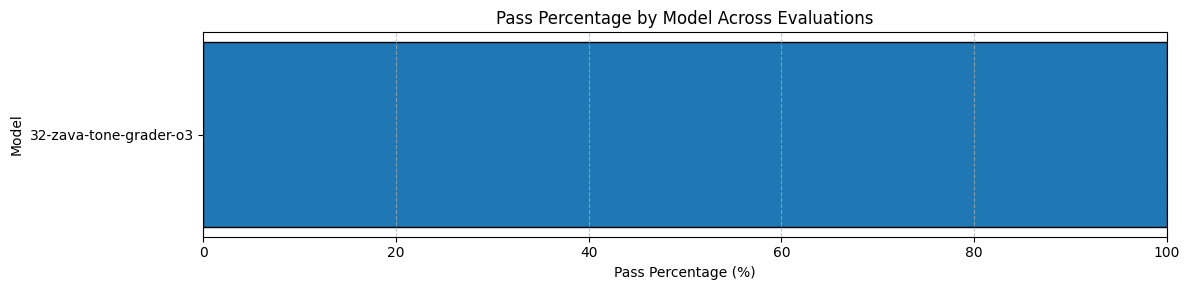

Fetching scores...

Score Summary Table:
Model             Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
 None zava-tone-baseline-f7749799          8.55      4.00     10.00            5.90            7.50           10.00           10.00           10.00


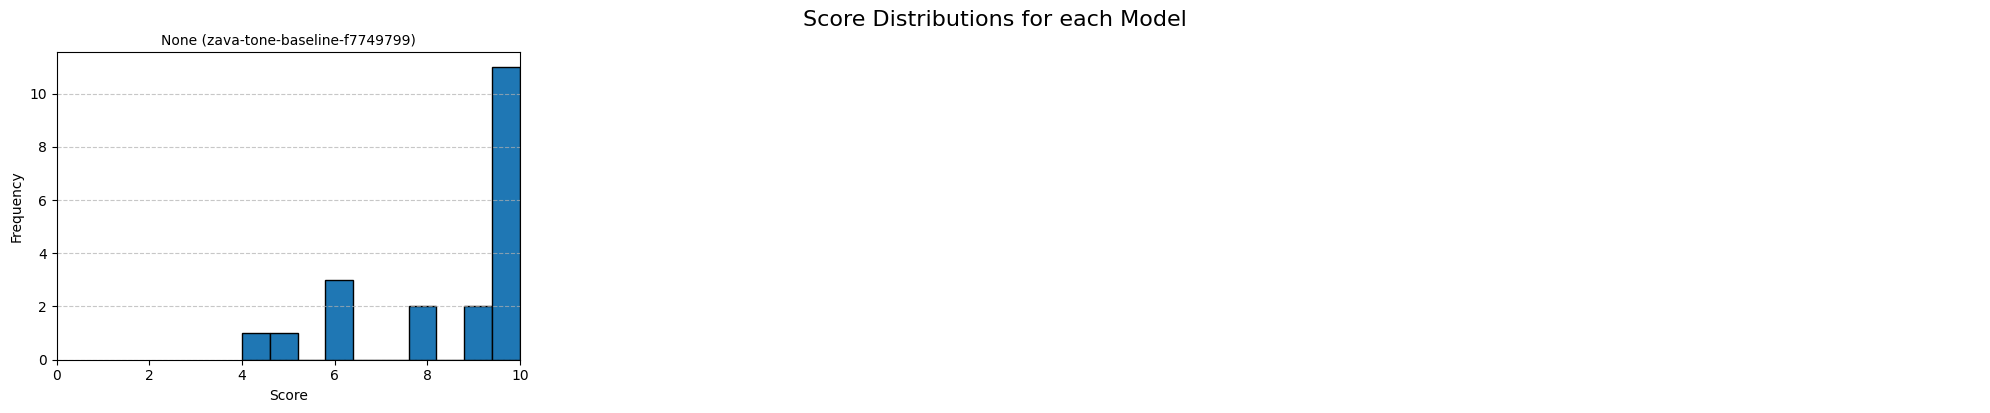

In [12]:
# We've got a handy script for rendering the results from an Evaluations Runs. Let's
# eyeball this stuff. It uses the Evals API to retrieve the scores and plot them.
from eval_utils import display_evaluation_summary

display_evaluation_summary(client, [grader_eval.id], x_range=(0, 10))

# We should see that our grader generally thinks our "gold standard" is pretty on-brand for Zava tone. 
# This is where we'd iterate on tuning the grader, making sure we
# clearly capture features for it to score, etc. We're keeping it simple for now.

---

## 3. Baseline Testing Our Candidate Models

### 3.1 Curate Q&A Dataset

In [13]:
import pandas as pd

# Read the JSONL file into a DataFrame and print the first 5 rows in 2 columns
qa_jsonl_df = pd.read_json("01-distill_sft_qa.jsonl", lines=True)
# Display all columns and set display width to show full text in the output
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)
pd.DataFrame(
    [
        {"question": row["item"]["question"], "answer": row["item"]["answer"]}
        for _, row in qa_jsonl_df.head(5).iterrows()
    ]
)


,question,answer
0,What's the best paint for kitchen walls?,Interior Semi-Gloss Paint is ideal for kitchens due to its moisture resistance and washable finish.
1,How much does Premium Interior Latex Flat cost?,$40.
2,What type of paint should I use for bathroom walls?,"Interior Semi-Gloss Paint, as it's moisture resistant and washable."
3,Is there an environmentally friendly paint option available?,"Yes, Zero VOC Interior Paint for healthy indoor air quality."
4,What's the price of Zero VOC Interior Paint?,$52.


### 3.2 Split Training & Validation

In [14]:
import json

qa = []
with open("01-distill_sft_qa.jsonl", "r") as f:
    for line in f.readlines():
        qa.append(json.loads(line))

print(f"Number of Q/A pairs: {len(qa)}")


Number of Q/A pairs: 306


In [15]:

# First we'll randomize it to maybe prove a point that this isn't totally staged 😜
from random import shuffle
shuffle(qa)

# Now we split 50/50.
split_at = int(len(qa) / 2)
qa_baseline = qa[:split_at]
qa_validation = qa[split_at:]

# Check it.
print(f"{len(qa_baseline)} pairs for baseline testing, {len(qa_validation)} for validation.")

153 pairs for baseline testing, 153 for validation.


### 3.3 Upload baseline (training) set

In [16]:
# Now we'll upload our baseline dataset and prepare our Evaluation. We need to save the data
# to disk first for...reasons...because of the OpenAI SDK. That's fine.
filename = f"./01-zava-tone-baseline-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_baseline:
        json.dump(row, f)
        f.write("\n")

baseline_file = None
with open(filename, "rb") as f:
    baseline_file = client.files.create(purpose="evals", file=f)
    baseline_file = client.files.wait_for_processing(baseline_file.id)

print(f"Created baseline file:\n{baseline_file.to_json(indent=2)}")

Created baseline file:
{
  "id": "file-d12b69e03f4448629bf0e0b24d04fac2",
  "bytes": 26425,
  "created_at": 1765620416,
  "filename": "01-zava-tone-baseline-f7749799.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


### 3.4 Create The Baseline Evaluation

In [17]:
# We'll now build out the Evaluation details. In this case, we'll *generate* responses
# using a base model, unlike before where we used the pre-canned results just to test
# the grader.

# We'll use a simple system prompt to show how distillation and fine-tuning let us
# get away without overly complex prompt engineering.
SYSTEM_PROMPT = "You are Cora, a polite, factual and helpful assistant for Zava, a DIY hardware store."

# We'll use a flee of base models as our baseline, including `o3-mini` (our grader).
BASE_MODELS = [
    "o3-mini",
    "o4-mini",
    "gpt-4.1-mini",
    "gpt-4o-mini",
    "gpt-4.1-nano",
]

# The prompt we'll grade will look like this pattern. Similar to before, but now we're
# going to use {{sample.output_text}} to substitute what the model under test generates.
USER_PROMPT = """
Q: {{item.question}}
A: {{sample.output_text}}
"""

# Input to our grader remains the same as before, but we reproduce it here for context.
INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# The schema and data source are similar, but with one major difference noted below.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    },
}
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}

# Same testing criteria, reproduced again for context.
TESTING_CRITERIA = {
    "name": "Zava Tone Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],
    "pass_threshold": 4.0,
}

# We create one Evaluation for *all* our base models. Each model is tested in a
# distinct Run that we'll define next.
baseline_eval = client.evals.create(
    name=f"32-zava-tone-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA]
)
print(f"⚖️ Created baseline eval {baseline_eval.id}")

⚖️ Created baseline eval eval_693d3ac13f288191ac151b1d9e7d6b7e


### 3.5 Run Baseline Evaluation

In [18]:
# Each run gets its own data source definition as it needs to specify a different
# model deployment to use for generation. The template is the prompt template
# sent to the model under test. It uses the simple Clippy system prompt and for
# the user input, we use the "question" from the baseline Q&A data file.
baseline_runs = []
for model in BASE_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": { "type": "file_id", "id": baseline_file.id },
        "input_messages": {
            "type": "template",
            "template": [
                { 
                    "type": "message", 
                    "role": "system", 
                    "content": { "type": "input_text", "text": SYSTEM_PROMPT },
                },
                { 
                    "type": "message", 
                    "role": "user", 
                    "content": { "type": "input_text", "text": "{{item.question}}" },
                },
            ],
        },
        "sampling_params": { "max_completions_tokens": 20_000 } if model.startswith("o") else { "max_completions_tokens": 100 }, # XXX
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}", 
        eval_id=baseline_eval.id,
        data_source=RUN_DATA_SOURCE, 
    )
    print(f"🏃‍➡️ Created run {run.id} for eval {baseline_eval.id}")
    baseline_runs.append(run)

🏃‍➡️ Created run evalrun_693d3ac43b38819182c7195b39fa9277 for eval eval_693d3ac13f288191ac151b1d9e7d6b7e
🏃‍➡️ Created run evalrun_693d3ac61e5c8191bcdd8127bd711bb1 for eval eval_693d3ac13f288191ac151b1d9e7d6b7e
🏃‍➡️ Created run evalrun_693d3ac832108191bd8d4d5773465efa for eval eval_693d3ac13f288191ac151b1d9e7d6b7e
🏃‍➡️ Created run evalrun_693d3acaea648191b3c87c115b708884 for eval eval_693d3ac13f288191ac151b1d9e7d6b7e
🏃‍➡️ Created run evalrun_693d3ace27a081918ccd18b782ad7881 for eval eval_693d3ac13f288191ac151b1d9e7d6b7e


### 3.6 Poll For Evaluation Results

In [19]:
# We now have to wait for our half-dozen or so Runs to finish. Twiddle your thumbs a bit!
from IPython.display import clear_output
import time

start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in baseline_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(baseline_runs)):
        baseline_runs[i] = client.evals.runs.retrieve(eval_id=baseline_eval.id, run_id=baseline_runs[i].id)
        print(f"🏃‍➡️ Run {baseline_runs[i].name}: {baseline_runs[i].status}")
    
    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(baseline_runs)} runs completed!")

🏃‍➡️ Run o3-mini-f7749799: completed
🏃‍➡️ Run o4-mini-f7749799: completed
🏃‍➡️ Run gpt-4.1-mini-f7749799: completed
🏃‍➡️ Run gpt-4o-mini-f7749799: completed
🏃‍➡️ Run gpt-4.1-nano-f7749799: completed
⏱️ Elapsed time: 15 minutes 25 seconds
🏁 All 5 runs completed!


### 3.7 Visualize Results & Pick Model

Get Evaluation Runs: eval_693d3ac13f288191ac151b1d9e7d6b7e

Combined Evaluation Summary
                                  Run ID              Run Name        Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                Evaluation Name
evalrun_693d3ac61e5c8191bcdd8127bd711bb1      o4-mini-f7749799      o4-mini completed           58.169935            41.176471 eval_693d3ac13f288191ac151b1d9e7d6b7e 32-zava-tone-baseline-f7749799
evalrun_693d3ac43b38819182c7195b39fa9277      o3-mini-f7749799      o3-mini completed           53.594771            45.751634 eval_693d3ac13f288191ac151b1d9e7d6b7e 32-zava-tone-baseline-f7749799
evalrun_693d3acaea648191b3c87c115b708884  gpt-4o-mini-f7749799  gpt-4o-mini completed           48.366013            43.790850 eval_693d3ac13f288191ac151b1d9e7d6b7e 32-zava-tone-baseline-f7749799
evalrun_693d3ac832108191bd8d4d5773465efa gpt-4.1-mini-f7749799 gpt-4.1-mini completed           41.176471            41.176471 e

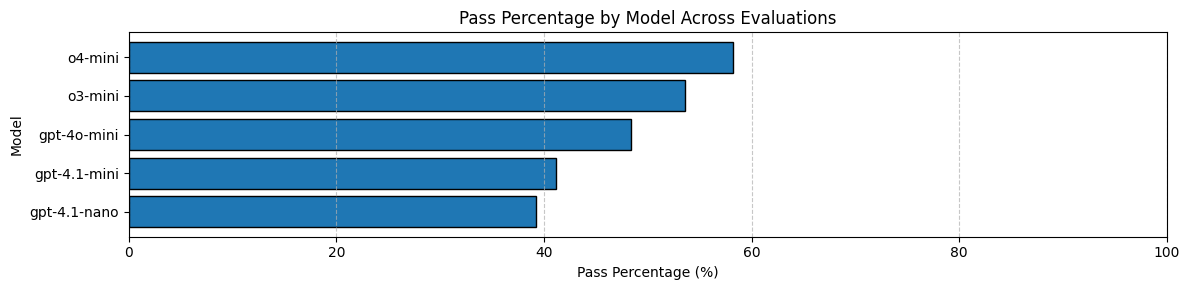

Fetching scores...

Score Summary Table:
       Model                Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
     o3-mini 32-zava-tone-baseline-f7749799          4.09      0.00      9.00            0.00            0.00            4.00            8.00            9.00
     o4-mini 32-zava-tone-baseline-f7749799          2.76      0.00      9.00            0.00            0.00            4.00            4.00            5.00
 gpt-4o-mini 32-zava-tone-baseline-f7749799          2.18      0.00      9.00            0.00            0.00            1.00            4.00            4.00
gpt-4.1-mini 32-zava-tone-baseline-f7749799          1.98      0.00      9.00            0.00            0.00            1.00            4.00            4.00
gpt-4.1-nano 32-zava-tone-baseline-f7749799          1.87      0.00     10.00            0.00            0.00            1.00            4.00            4.00


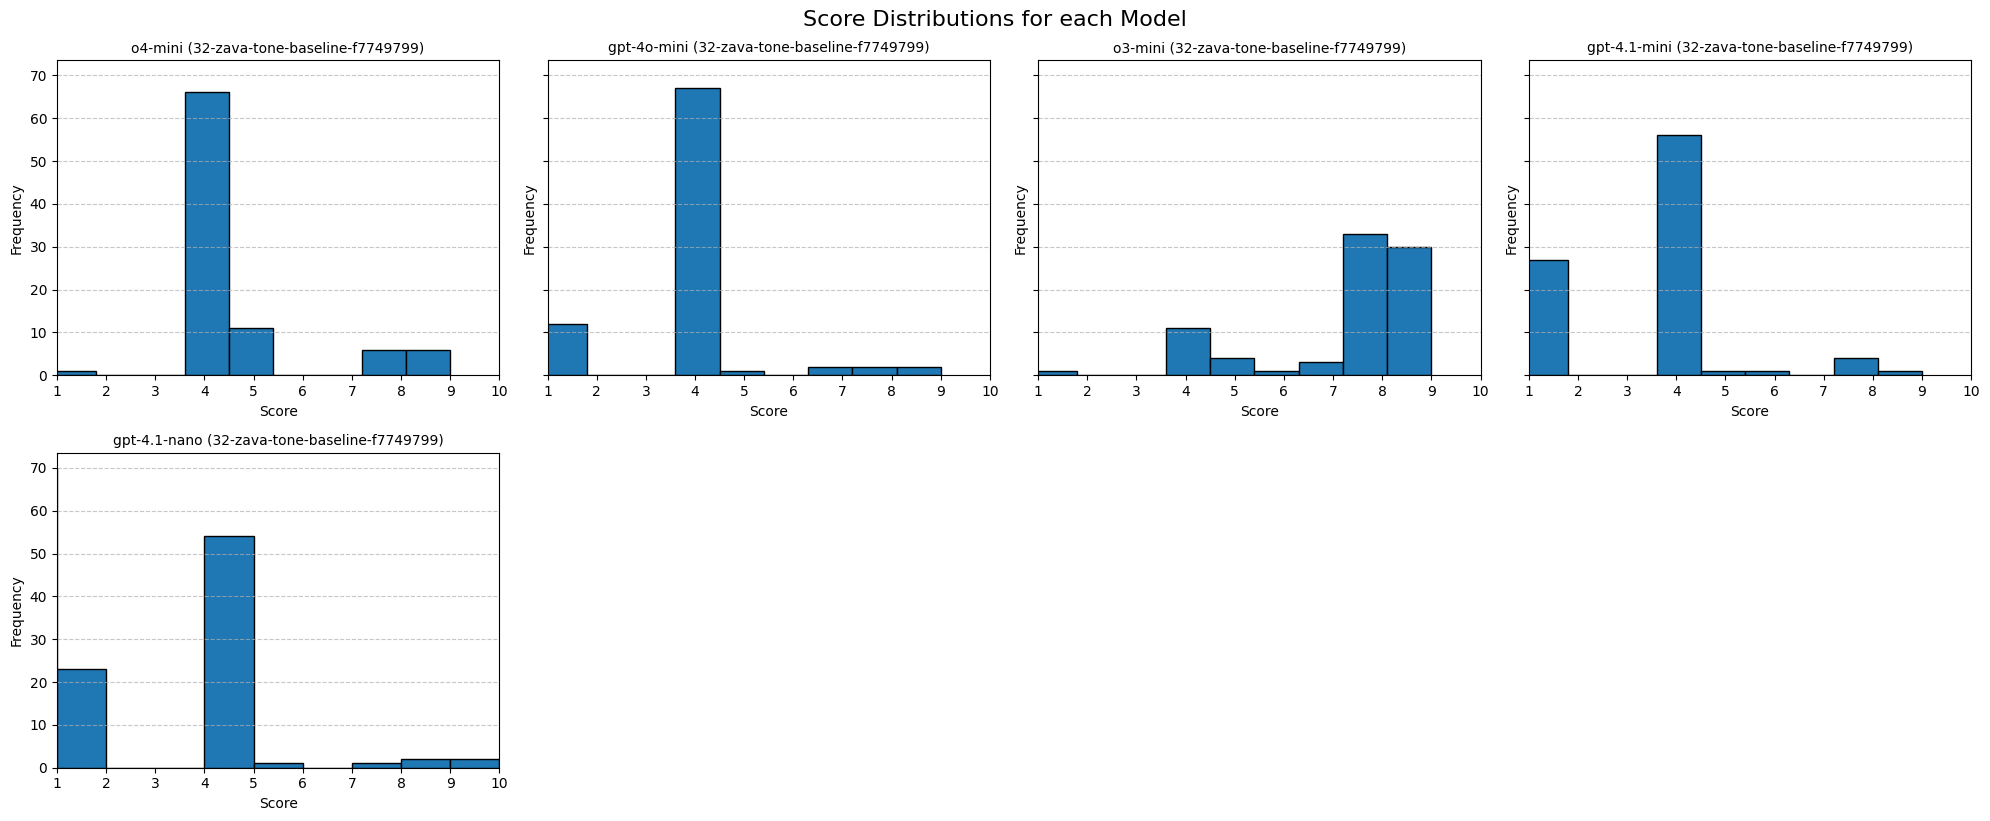

In [20]:
# Let's visualize our evaluation and identify the best and worst performers.
display_evaluation_summary(client, [baseline_eval.id], x_range=(1, 10))

In [21]:
import pickle
import json

# Save the evaluation objects and runs
export_data = {
    'baseline_eval_id': baseline_eval.id,
    'baseline_runs_ids': [run.id for run in baseline_runs],
    'baseline_runs_models': [run.model for run in baseline_runs],
    'qa_validation': qa_validation,
    'GRADER_MODEL': GRADER_MODEL,
    'GRADER_PROMPT': GRADER_PROMPT,
    'SYSTEM_PROMPT': SYSTEM_PROMPT,
    'UNIQUE_ENOUGH_KEY': UNIQUE_ENOUGH_KEY
}

# Save to a JSON file
with open('01-distillation_export.json', 'w') as f:
    json.dump(export_data, f, indent=2)

print("✅ Exported data for distillation notebook")

✅ Exported data for distillation notebook


## Step 8: Summary & Results

Congratulations! You've successfully implemented **model distillation** using Microsoft Foundry's evaluation and fine-tuning capabilities. Here's what you accomplished:

### 🎯 Distillation Achievement

**Teacher → Student Transfer**: Successfully distilled specialized Zava customer service knowledge from a large reasoning model (GPT-4) into a much smaller, faster model (GPT-4.1-nano) while maintaining quality standards.

### 🏆 Key Accomplishments

1. **✅ Custom Grader Creation**: Built a reliable evaluator using AI-assisted evaluation (LLM-as-a-Judge) with business-specific criteria
2. **✅ Baseline Establishment**: Curated gold standard responses from successful fine-tuning data
3. **✅ Quality Measurement**: Validated grader effectiveness on baseline data
4. **✅ Knowledge Transfer**: Used distillation to transfer specialized capabilities to smaller model
5. **✅ Performance Optimization**: Achieved cost and latency improvements while preserving quality

### 📊 Business Impact

- **🤑 Cost Reduction**: Smaller models use fewer tokens per inference, significantly reducing operational costs
- **🏎️ Performance Boost**: Faster response times improve customer experience and system throughput  
- **🎯 Quality Maintained**: Custom grader ensures distilled model meets Zava's tone and style standards
- **📈 Scalability**: Efficient model allows handling higher customer volumes

### 🧠 Technical Innovation

**No Manual Training Data**: Achieved distillation without creating training examples manually - just by defining evaluation criteria and letting AI systems handle the knowledge transfer process.

**Automated Pipeline**: Combined Azure AI Evaluations and Fine-Tuning to create an automated distillation workflow.

**Objective Measurement**: Used consistent grading criteria throughout the process to validate improvement.

---

**🎉 You've mastered the art of cost-effective AI model optimization through distillation!**